In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from matplotlib.colors import ListedColormap

sns.set_style('white')

plt.rc('font', family='sans-serif')
plt.rc('font', serif='Arial')
plt.rc('text', usetex='false')

try:
    plt.style.use('../custom.mplstyle')
except IOError:
    plt.rc('font', size=10)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes', labelsize=12, titlesize=12)
    plt.rc('legend', fontsize=8)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.metrics import precision_recall_curve, auc

In [3]:
a = pd.read_table('../input/chemical/emap.matrix.txt')
a.set_index(a.columns[0],
            inplace=True)
f = pd.read_table('../input/chemical/emap.fdr.txt')
f.set_index(f.columns[0],
            inplace=True)
v = a[a < 0][f < 0.05]
v[np.invert(np.isnan(v))] = 1
v[np.isnan(v)] = 0
v[np.isnan(a)] = np.nan

In [4]:
strains = {x for x in v.index
           if x.startswith('NT12')
           and int(x[2:]) >= 12620}
nstrains = {x for x in v.index
            if x.startswith('NT12')
            and int(x[2:]) < 12620}

In [5]:
m = pd.read_table('../sickness/123456/weighted_score.2.txt')
m.set_index(m.columns[0], inplace=True)
m.index.name = 'condition'
m = m.T

In [6]:
m1 = m.loc[strains]
a1 = a.loc[strains]
v1 = v.loc[strains]
m2 = m.loc[nstrains]
a2 = a.loc[nstrains]
v2 = v.loc[nstrains]

In [7]:
p = pd.read_table('../sickness/123456/auc_weighted_score.2.txt',
                  header=None)
p = p[p[7] == 'prec']
pdict = p.groupby(0).mean().dropna()[3].to_dict()

In [8]:
res = []
for c in set(m.columns).intersection(a.columns):
    idx = set(m[c].dropna().index).intersection(a[c].dropna().index)
    lreg = stats.linregress(m.loc[idx, c],
                            a.loc[idx, c])
    sreg = stats.spearmanr(m.loc[idx, c],
                           a.loc[idx, c])
    ridx = v[v == 0].loc[idx,
                         c].dropna().sample(n=50).index
    ridx = set(ridx).union(v[v == 1].loc[idx,
                                         c].dropna().index)
    lrreg = stats.linregress(m.loc[ridx, c],
                            a.loc[ridx, c])
    srreg = stats.spearmanr(m.loc[ridx, c],
                           a.loc[ridx, c])
    res.append((c, pdict.get(c, np.nan),
                lreg.rvalue, lreg.pvalue,
                sreg.correlation, sreg.pvalue,
                lrreg.rvalue, lrreg.pvalue,
                srreg.correlation, srreg.pvalue,
                v.loc[idx, c].dropna().sum(),
                v.loc[idx, c].dropna().sum() / a.loc[idx, c].dropna().shape[0]))
df = pd.DataFrame(res)
df.columns = ['condition',
              'pr-auc',
              'rvalue', 'pvalue',
              'svalue', 'spvalue',
              'rvalue_reduced', 'pvalue_reduced',
              'svalue_reduced', 'spvalue_reduced',
              'sick',
              'psick']
df['pvalue_corrected'] = multipletests(df.pvalue,
                                       method='fdr_by')[1]
df['pvalue_reduced_corrected'] = multipletests(df['pvalue_corrected'],
                                       method='fdr_by')[1]
df['spvalue_corrected'] = multipletests(df.spvalue,
                                       method='fdr_by')[1]

/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x

In [9]:
print('Proportion of well-predicted conditions (sick strains >= 1%)')
df[(df.psick >= 0.01) &
               (df.pvalue_corrected <= 0.01) &
               (df['pr-auc'] >= 0.1)].shape[0] / df[df.psick >= 0.01].shape[0]

Proportion of well-predicted conditions (sick strains >= 1%)


0.2

In [10]:
print('Proportion of well-predicted conditions (sick strains >= 5%)')
df[(df.psick >= 0.05) &
               (df.pvalue_corrected <= 0.01) &
               (df['pr-auc'] >= 0.1)].shape[0] / df[df.psick >= 0.05].shape[0]

Proportion of well-predicted conditions (sick strains >= 5%)


0.3888888888888889

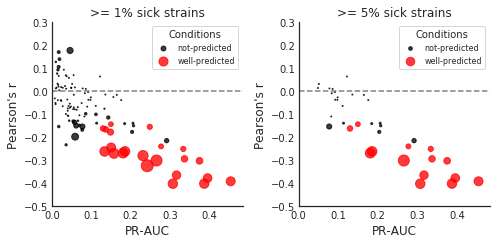

In [11]:
plt.figure(figsize=(7, 3.5))

well_1 = df[(df.psick >= 0.01) &
            (df.pvalue_corrected <= 0.01) &
            (df['pr-auc'] >= 0.1)]
not_1 = df.loc[set(df[(df.psick >= 0.01)].index).difference(well_1.index)]

plt.subplot(121)
plt.title('>= 1% sick strains')
plt.scatter(not_1['pr-auc'],
            not_1.rvalue,
            (-np.log10(not_1['pvalue_corrected']) + 0.1)*10,
            color='k',
            label='not-predicted',
            alpha=0.77)

plt.scatter(well_1['pr-auc'],
            well_1.rvalue,
            (-np.log10(well_1['pvalue_corrected']) + 0.1)*10,
            color='r',
            label='well-predicted',
            alpha=0.77)

plt.xlabel('PR-AUC')
plt.ylabel('Pearson\'s r')
plt.ylim(-0.5, 0.3)

plt.legend(title='Conditions',
           frameon=True,
           loc='upper center',
           bbox_to_anchor=(0.75, 1))

plt.axhline(0,
            color='grey',
            ls='dashed')
plt.xlim(0)

well_1 = df[(df.psick >= 0.05) &
            (df.pvalue_corrected <= 0.01) &
            (df['pr-auc'] >= 0.1)]
not_1 = df.loc[set(df[(df.psick >= 0.05)].index).difference(well_1.index)]

plt.subplot(122)
plt.title('>= 5% sick strains')
plt.scatter(not_1['pr-auc'],
            not_1.rvalue,
            (-np.log10(not_1['pvalue_corrected']) + 0.1)*10,
            color='k',
            label='not-predicted',
            alpha=0.77)

plt.scatter(well_1['pr-auc'],
            well_1.rvalue,
            (-np.log10(well_1['pvalue_corrected']) + 0.1)*10,
            color='r',
            label='well-predicted',
            alpha=0.77)

plt.xlabel('PR-AUC')
plt.ylabel('Pearson\'s r')

plt.axhline(0,
            color='grey',
            ls='dashed')
plt.xlim(0)
plt.ylim(-0.5, 0.3)

plt.legend(title='Conditions',
           frameon=True,
           loc='upper center',
           bbox_to_anchor=(0.75, 1))

plt.tight_layout()
sns.despine()
plt.savefig('sfig4a.svg',
            dpi=150);

In [12]:
import numpy as np
import pandas as pd
from Bio import Phylo
from sklearn.metrics import precision_recall_curve, auc

In [13]:
t = Phylo.read('../input/tree.nwk', 'newick')
ref = None
for x in t.get_terminals():
    x.name = x.name.split('_')[0]
    if 'genome' in x.name:
        x.name = 'NT12001'
        ref = x

In [14]:
a = pd.read_table('../input/chemical/emap.matrix.txt')
a.set_index(a.columns[0],
            inplace=True)
f = pd.read_table('../input/chemical/emap.fdr.txt')
f.set_index(f.columns[0],
            inplace=True)
v = a[a < 0][f < 0.05]
v[np.invert(np.isnan(v))] = 1
v[np.isnan(v)] = 0
v[np.isnan(a)] = np.nan

In [15]:
distant = [x[0] for x in sorted([(x.name, t.distance(ref, x))
                                 for x in t.get_terminals()],
                                key=lambda x: x[1])[-100:]]

In [16]:
m = pd.read_table('../sickness/123456/weighted_score.2.txt')
m.set_index(m.columns[0], inplace=True)
m.index.name = 'condition'
m = m.T

In [17]:
m1 = m.loc[[x for x in m.index
            if x not in distant]]
v1 = v.loc[[x for x in m.index
            if x not in distant]]
m = m.loc[distant]
v = v.loc[distant]

In [18]:
res = []
for c in set(m.columns).intersection(a.columns):
    idx = sorted(set(m[c].dropna().index).intersection(v[c].dropna().index))
    if len(idx) == 0:
        continue
    prec, rec, thresholds = precision_recall_curve(v.loc[idx, c],
                                                   m.loc[idx, c])
    res.append((c, v.loc[idx, c].sum(), auc(rec, prec)))
r = pd.DataFrame(res)
r.columns = ['condition',
             'phenotypes',
             'auc']

/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [19]:
res1 = []
for c in set(m.columns).intersection(a.columns):
    idx = sorted(set(m1[c].dropna().index).intersection(v1[c].dropna().index))
    if len(idx) == 0:
        continue
    prec, rec, thresholds = precision_recall_curve(v1.loc[idx, c],
                                                   m1.loc[idx, c])
    res1.append((c, v1.loc[idx, c].sum(), auc(rec, prec)))
r1 = pd.DataFrame(res1)
r1.columns = ['condition',
              'phenotypes',
              'auc']

/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:420: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [20]:
p = pd.read_table('../sickness/123456/auc_weighted_score.2.txt',
                  header=None)

In [21]:
r['aauc'] = [p[(p[0] == x) &
               (p[7] == 'prec')][3].values[0]
             for x in r['condition']]

In [22]:
r['dauc'] = [r1[r1.condition == x]['auc'].values[0]
             for x in r['condition']]

In [23]:
r.set_index('condition', inplace=True)

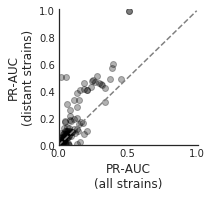

In [24]:
plt.figure(figsize=(2.5, 2.5))

plt.plot(r.aauc,
         r.auc,
         'ko',
         alpha=0.3)

plt.plot([0, 1],
         [0, 1],
         '--',
         color='grey')
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)

plt.xlabel('PR-AUC\n(all strains)')
plt.ylabel('PR-AUC\n(distant strains)')
sns.despine()
plt.savefig('sfig4b.svg');

In [25]:
import gseapy
import numpy as np
import pandas as pd
from scipy import stats

In [26]:
a = pd.read_table('../input/chemical/emap.matrix.txt')
a.set_index(a.columns[0], inplace=True)
f = pd.read_table('../input/chemical/emap.fdr.txt')
f.set_index(f.columns[0], inplace=True)
v = a[f < 0.05]
v = v[v < 0]
v[np.invert(np.isnan(v))] = 1
v[np.isnan(v)] = 0
v[np.isnan(a)] = np.nan

In [27]:
m = pd.read_table('../sickness/123456/weighted_score.2.txt')
m.set_index(m.columns[0], inplace=True)
m = m.T

In [28]:
def gsea(m, a, v):
    for c in set(m.columns).intersection(v.columns):
        idx = set(m[c].dropna().index).intersection(a[c].dropna().index)
        midx = m.loc[idx, c].sort_values(ascending=False).index
        rank = m.loc[midx, c].reset_index()
        if v[v == 1].loc[midx, c].dropna().shape[0] <= 1:
            # print(c, v[v == 1].loc[midx, c].dropna().shape[0])
            continue
        f = open('set.gmt', 'w')
        f.write('\t'.join([c, ''] + list(v[v == 1].loc[midx, c].dropna().index)))
        f.write('\n')
        f.close()
        yield gseapy.prerank(rnk=rank, gene_sets='set.gmt', outdir='prerank_gsea',
                             min_size=1)

In [29]:
g = pd.concat([x.res2d for x in gsea(m, a, v)])

/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/gseapy/algorithm.py:81: RuntimeWarning: divide by zero encountered in true_divide
  norm_tag =  1.0/sum_correl_tag
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/gseapy/algorithm.py:84: RuntimeWarning: invalid value encountered in multiply
  RES = np.cumsum(tag_indicator * correl_vector * norm_tag - no_tag_indicator * norm_no_tag, axis=axis)
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/gseapy/algorithm.py:88: RuntimeWarning: invalid value encountered in greater
  es = np.where(np.abs(max_ES) > np.abs(min_ES), max_ES, min_ES)
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/gseapy/algorithm.py:492: RuntimeWarning: invalid value encountered in less
  choicelist = [np.sum(esnull < es.reshape(len(es),1), axis=1)/ np.sum(esnull < 0, axis=1),
/hps/nobackup/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/gseapy/algorithm.py

In [30]:
p = pd.read_table('../sickness/123456/auc_weighted_score.2.txt',
                  header=None)
p.columns = ['condition',
             'sick', 'strains',
             'stat', 'threshold',
             'x', 'y', 'kind']
p = p[p.kind == 'prec'].groupby('condition').max()['stat'].dropna().to_dict()

In [31]:
g['pr-auc'] = [p.get(x) for x in g.index]

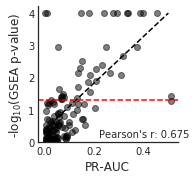

In [32]:
plt.figure(figsize=(2.5, 2.5))

l = stats.linregress(g['pr-auc'],
                     -np.log10(g['pval'] + 0.0001))
plt.plot(g['pr-auc'],
         -np.log10(g.pval + 0.0001),
         'ko',
         alpha=0.5)

fn = l.intercept + l.slope * np.linspace(0, 0.5)
plt.plot(np.linspace(0, 0.5),
         fn,
         'k--')

plt.axhline(-np.log10(0.05),
            color='r',
            linestyle='dashed')
plt.ylim(0, 4.2)

plt.text(0.22,
         0.15,
         'Pearson\'s r: %.3f' % l.rvalue)

plt.xlabel('PR-AUC')
plt.ylabel('-log$_{10}$(GSEA p-value)')

# plt.yscale('log')
sns.despine()
plt.savefig('sfig4c.svg', dpi=150)

In [33]:
p = pd.read_table('../sickness/123456/auc_weighted_score.2.txt',
                  header=None)
p.columns = ['condition',
             'sick', 'strains',
             'stat', 'threshold',
             'x', 'y', 'kind']
p = p[p.kind == 'prec'].groupby('condition').max()['stat'].dropna().to_dict()

In [34]:
q = pd.read_table('../sickness/123456/auc_score.2.txt',
                  header=None)
q.columns = ['condition',
             'sick', 'strains',
             'stat', 'threshold',
             'x', 'y', 'kind']
q = q[q.kind == 'prec'].groupby('condition').max()['stat'].dropna().to_dict()

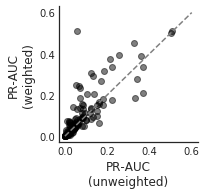

In [35]:
plt.figure(figsize=(2.5, 2.5))

idx = set(p).intersection(q)

plt.plot([q[x] for x in idx],
         [p[x] for x in idx],
         'ko',
         alpha=0.5)
plt.plot([0, 0.6],
         [0, 0.6],
         '--',
         color='grey')

plt.xlabel('PR-AUC\n(unweighted)')
plt.ylabel('PR-AUC\n(weighted)')

sns.despine()
plt.savefig('sfig4d.svg', dpi=150)

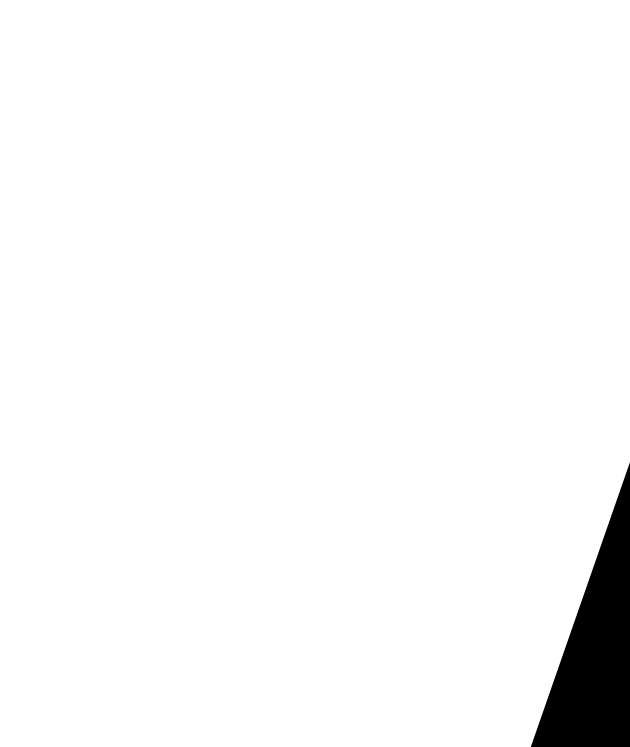

In [36]:
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("7in", "8.3in")

# load matpotlib-generated figures
fig1 = sg.fromfile('../plots/conditions_all_auc.svg')
fig2 = sg.fromfile('sfig4a.svg')
fig3 = sg.fromfile('sfig4b.svg')
fig4 = sg.fromfile('sfig4c.svg')
fig5 = sg.fromfile('sfig4d.svg')

# get the plot objects
plot1 = fig1.getroot()
plot1.moveto(60, 0, scale=1)
plot2 = fig2.getroot()
plot2.moveto(0, 270, scale=1)
# plot3 = fig3.getroot()
# plot3.moveto(45, 530, scale=1)
plot4 = fig4.getroot()
plot4.moveto(55, 530, scale=1)
plot5 = fig5.getroot()
plot5.moveto(310, 530, scale=1)

# add text labels
txt1 = sg.TextElement(5,  10, "A)", size=12, weight="bold")
txt2 = sg.TextElement(5,  275, "B)", size=12, weight="bold")
txt3 = sg.TextElement(250,  275, "C)", size=12, weight="bold")
# txt4 = sg.TextElement(25,  530, "D)", size=12, weight="bold")
txt5 = sg.TextElement(5,  530, "D)", size=12, weight="bold")
txt6 = sg.TextElement(250,  530, "E)", size=12, weight="bold")

# append plots and labels to figure
fig.append([plot1, plot2, plot4, plot5])
fig.append([txt1, txt2, txt3, txt5, txt6])

# save generated SVG files
fig.save("../figures/supplementary/sfig4.svg")

!convert ../figures/supplementary/sfig4.svg sfig4.png

from IPython.display import Image
Image(filename='sfig4.png')